# Fine-tuning GPT-2 for Gen-Z Style Rewriting

- We will try to fine-tune GPT-2 to rewrite formal text into Gen Z style.
- For this, we will be using something called **knowledge distillation**.
- What is knowledge distillation, you might ask?
  - It's when you train / fine-tune a smaller model on a bigger model’s outputs.
  - The big model is called the **teacher model**, and the small model is, well, you probably guessed it, the **student model**.
- So how exactly will we be doing that?
  - We will be generating synthetic data, some call this process **data augmentation**, using the Magistral Small model.
    - The script for this is provided: `get_pairs_magistral`. You can take a look, but Magistral Small requires a powerful GPU to run. You might be able to run it with an RTX 4090 (if quantized), but I would assume most of you don’t have this kind of compute power available, so you can simply look at the script, it's very straight to the point.
    - The output of Magistral Small is pairs of formal text and Gen Z text.
  - We will use the output of Magistral Small throughout the exercise. The file that contains our pairs is `genz_pairs_magistral_diverse_5k.jsonl`.  
    (A small note if you’re interested: JSONL is used instead of JSON because JSONL supports streaming the inference output directly, so we don’t have to wait for the whole pipeline to end to get our data.)
- HAVE FUN!


In [20]:
import math
import torch
import pandas as pd
from datasets import Dataset, DatasetDict
from torch.nn.utils.rnn import pad_sequence
import textwrap
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

from transformers import (
    GPT2TokenizerFast,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# some colors to add some soul
RED = "\033[91m"
BLUE = "\033[94m"
BOLD = "\033[1m"
RESET = "\033[0m"

## Load JSONL Style-Transfer Dataset

Your dataset contains pairs:
```
{"original": "I am tired", "gen_z": "lowkey exhausted fr"}
```

In [ ]:
jsonl_path = "genz_pairs_magistral_diverse_5k.jsonl"

df = pd.read_json(jsonl_path, lines=True)
print("Dataset size:", len(df))
df.head()

Dataset size: 5001


,original,gen_z
0,I am really tired after studying all night.,Been grinding all night and I’m lowkey exhaust...
1,I can't believe how many people are playing th...,It's crazy how many people are playing that ne...
2,I need to finish this report by the end of the...,"Gotta wrap up this report by EOD, ya feel me?"
3,I always check my phone when I wake up in the ...,"First thing in the morning, I always gotta che..."
4,I always make time for my friends even when I'...,"No matter how busy I am, I always make time fo..."


## Train / Validation Split
- Tasks: usually we create 3 splits: train, validation, test. But this task is more about creativity, there are methods where we can test our output for stylistic rewriting, but the pairs themselves were generated using another LLM, so I think after we finish fine-tuning our mode, judge it yourself!
    - Task 1: 80% train + 20% dev

In [3]:
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

dataset = DatasetDict({
    # --- Task 1 begins here ---
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'validation': Dataset.from_pandas(val_df.reset_index(drop=True))
    # --- Task 1 ends here ---
})

dataset

DatasetDict({
    train: Dataset({
        features: ['original', 'gen_z'],
        num_rows: 4001
    })
    validation: Dataset({
        features: ['original', 'gen_z'],
        num_rows: 1000
    })
})

## Tokenizer & Pair Formatting
- Explanation of the next steps:
    - GPT-2 is a causal language model. That means it learns by predicting the next token given everything before it.
        - So during training, GPT-2 assumes:
            - Every token in the input is something it should try to predict.
            - But in our task, the input contains two parts:
                -  `Original: <formal text> Gen Z:`
            - Our target output is this:
                - `<gen-z rewrite>`
            - We do not want GPT-2 to learn the prompt, only the Gen-Z rewrite.
            - That’s why we need to:
                - concatenate prompt + output into one sequence
                - but mask the prompt labels with -100

- Tasks: let's create our tokenization function
    - Task 1: format your prompt + target
    - Task 2: tokenize?
    - Task 3: build your model input (truncation for safety!) + your labels (remember we don't want our model to learn the prompt, this is very essential for style transfer. Hint: -100 for masking)
    - Task 4: tokenize your data

In [8]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

prompt_template = "Original: {src}\nGen Z: "
MAX_LEN = 1024

def tokenize_pair(example):
    # --- Task 1 begins here ---
    prompt = prompt_template.format(src=example['original'])
    target = example['gen_z'] + tokenizer.eos_token
    # --- Task 1 ends here ---

    # --- Task 2 begins here ---
    prompt_ids = tokenizer(prompt, add_special_tokens=False)['input_ids']
    target_ids = tokenizer(target, add_special_tokens=False)['input_ids']
    # --- Task 2 ends here ---
    
    # --- Task 3 begins here ---
    input_ids = (prompt_ids + target_ids)[:MAX_LEN]
    labels = ([-100] * len(prompt_ids) + target_ids)[:MAX_LEN]
    # --- Task 3 ends here ---
    
    return {
        'input_ids': input_ids,
        'labels': labels
    }

# --- Task 4 begins here ---
tokenized_datasets = dataset.map(tokenize_pair)
# --- Task 4 ends here ---
tokenized_datasets = tokenized_datasets.remove_columns(['original','gen_z'])
tokenized_datasets.set_format('torch')
tokenized_datasets

Map:   0%|          | 0/4001 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 4001
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1000
    })
})

## Data Collator: Dynamic Padding and Masking

- We want our batches to look like this at training time:
```txt
[input_ids]      → padded to max seq len in batch

[labels]         → padded, but masked with -100

[attention_mask] → tells the model which tokens are padding
```
- Unlike tokenization (which truncates), batching must:
    - Dynamically pad sequences in each batch
    - Mask padded label tokens with -100
    - Ensure padding does NOT affect loss
    - Produce a valid attention_mask
- Tasks:
    - Task 1: store the tokenizer inside the collator
    - Task 2: extract tensors from features (input_ids, labels)
    - Task 3: dynamically pad inputs (Pad with pad_token_id)
    - Task 4: dynamically pad labels (Pad with -100 — so loss ignores padding)
    - Task 5: build attention mask (1 for tokens, 0 for padding)

In [ ]:
class CausalGenZCollator:
    def __init__(self, tokenizer):
        # --- Task 1 begins here ---
        self.tokenizer = tokenizer
        # --- Task 1 ends here ---

    def __call__(self, features):
        # --- Task 2 begins here ---
        input_ids  = [torch.tensor(f['input_ids']) for f in features]
        labels     = [torch.tensor(f['labels']) for f in features]
        # --- Task 2 ends here ---
        
        # --- Task 3 begins here ---
        input_ids = pad_sequence(
            input_ids,
            batch_first=True,
            padding_value=self.tokenizer.pad_token_id
        )
        # --- Task 3 ends here ---

        labels = pad_sequence(
            labels,
            batch_first=True,
            padding_value=-100
        )
        # --- Task 4 begins here ---
        
        # --- Task 5 begins here ---
        attention_mask = input_ids.ne(self.tokenizer.pad_token_id).long()
        # --- Task 5 ends here ---
        
        return {
            'input_ids': input_ids,
            'labels': labels,
            'attention_mask': attention_mask
        }

data_collator = CausalGenZCollator(tokenizer)

## Baseline GPT-2 (No Fine-tuning)

- Before we fine-tune GPT-2, we want to know:
    - How well does the pretrained model already perform on our Gen-Z rewriting task?
- We’ll evaluate GPT-2 without training to compute:
```txt
baseline loss  → cross-entropy on validation set
baseline ppl   → perplexity (exp(loss))
```
- This gives us a reference score so we can measure:
    - how much fine-tuning improves the model
    - whether our training setup actually helps
    - whether we’re overfitting or degrading performance
- We did this in previous exercies, before attempting to change things, we need to set a baseline!

- Tasks:
    - Task 1: load the `gpt2`
    - Task 2: define evaluation-only training arguments (let's go with `batch_size = 4`)
    - Task 3: create a Trainer for evaluation
    - Task 4: run evaluation on the validation split
    - Task 5: calculate the perplexity from loss

In [21]:
# --- Task 1 begins here ---
baseline_model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
# --- Task 1 ends here ---

baseline_model.resize_token_embeddings(len(tokenizer))

# --- Task 2 begins here ---
baseline_args = TrainingArguments(
    output_dir='./gpt2_genz_baseline',
    per_device_eval_batch_size=4,
    report_to='none'
)
# --- Task 2 ends here ---

# --- Task 3 begins here ---
baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_args,
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator
)
# --- Task 3 ends here ---

# --- Task 4 begins here ---
baseline_eval = baseline_trainer.evaluate()
# --- Task 4 ends here ---

# --- Task 5 begins here ---
baseline_loss = baseline_eval['eval_loss']
baseline_ppl = math.exp(baseline_loss)
# --- Task 5 ends here ---

print(f"Baseline perplexity: {baseline_ppl:.2f}")

Baseline perplexity: 21.86


## Fine-tune GPT-2 on Gen-Z pairs
- A quick recap of our training objective:
```txt
Input  → "Original: <text>"
Output → "Gen Z: <rewritten text>"
```
- Tasks:
    - Task 1: define our training arguments (`batch_size = 4`)
    - Task 2: initialize the Trainer
    - Task 3: let's fine-tune!

In [22]:
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
model.resize_token_embeddings(len(tokenizer))

# --- Task 1 begins here ---
training_args = TrainingArguments(
    output_dir='./finetuned_gpt2_genz',
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_strategy='epoch',
    logging_steps=20,
    report_to='none'
)
# --- Task 1 ends here ---

# --- Task 2 begins here --- 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator
)
# --- Task 2 ends here ---

# --- Task 3 begins here ---
trainer.train()
# --- Task 3 ends here ---

Step,Training Loss
20,2.518200
40,2.193700
60,1.934400
80,1.977800
100,1.901100
120,1.748800
140,1.596500
160,1.753800
180,1.698100
200,1.589400


TrainOutput(global_step=1001, training_loss=1.5254824745071518, metrics={'train_runtime': 155.7497, 'train_samples_per_second': 25.689, 'train_steps_per_second': 6.427, 'total_flos': 257429298816000.0, 'train_loss': 1.5254824745071518, 'epoch': 1.0})

## Evaluation After Fine-tuning
- Now that we fine-tuned our model, let's compare the perplexity before and after fine-tuning
- Tasks:
    - Task 1: get the evaluation results
    - Task 2: compute the perplexity after fine-tuning
    - Task 3: plot a simple bar chart to visualize the difference (use `pyplot`)

Perplexity after fine-tuning: 3.38


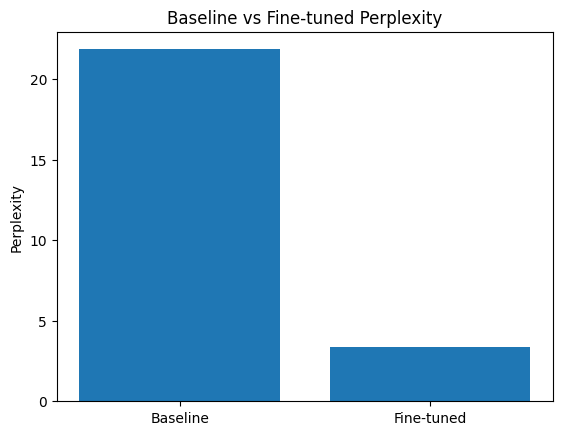

In [23]:
# --- Task 1 begins here ---
eval_results = trainer.evaluate()
# --- Task 1 ends here ---

# --- Task 2 begins here ---
eval_loss = eval_results['eval_loss']
eval_ppl = math.exp(eval_loss)
# --- Task 2 ends here ---

print(f"Perplexity after fine-tuning: {eval_ppl:.2f}")

metrics = ["Baseline", "Fine-tuned"]
values = [baseline_ppl, eval_ppl]

# --- Task 3 begins here ---
plt.figure()
plt.bar(metrics, values)
plt.ylabel("Perplexity")
plt.title("Baseline vs Fine-tuned Perplexity")
plt.show()
# --- Task 3 ends here ---

## Try Gen-Z Rewrite Generation
- Now let's see how's our small fine-tuned model doing
- You have written functions to run inference before, so this time I'll give it to you on a silver platter :D

In [25]:
def rewrite_gen_z(text):
    prompt = prompt_template.format(src=text)
    inputs = tokenizer(prompt, return_tensors='pt').to(device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_length=400,
            do_sample=True,
            top_p=0.95,
            top_k=50,
            pad_token_id=tokenizer.eos_token_id
        )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    return decoded.split("Gen Z:")[-1].strip()

sample = "I've been trying to balance my work, studies, and social life lately, but it feels like everything keeps happening at once. I’m grateful for the opportunities I have, yet I can’t deny that the constant pressure is starting to wear me down. Sometimes I just want a quiet evening to disconnect from notifications, clear my thoughts, and remind myself that I don’t have to keep up with everyone all the time."
original = textwrap.fill(sample, width=76)
gen_z = textwrap.fill(rewrite_gen_z(sample), width=76)

print(f"{BOLD}{RED}Original {RESET}")
print("=" * 80)
print(original)
print(f"{BOLD}{BLUE}Gen-Z {RESET}")
print("=" * 80)
print(gen_z)
print("=" * 80)

Original 
I've been trying to balance my work, studies, and social life lately, but it
feels like everything keeps happening at once. I’m grateful for the
opportunities I have, yet I can’t deny that the constant pressure is
starting to wear me down. Sometimes I just want a quiet evening to
disconnect from notifications, clear my thoughts, and remind myself that I
don’t have to keep up with everyone all the time.
Gen-Z 
I’ve been keeping my work and studies in check since I left school. It’s
tough to stop it when life’s always a little bit too much. It’s kinda
stressing me out right now, but I’m glad I got what I needed, but the
pressure is just so much and it’s making me uncomfortable. Sometimes I just
wanna check my phone for notifications, clear my head, and just take time
out to relax.
